In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from utils import *
import copy
import math

%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


ModuleNotFoundError: No module named 'seaborn'

In [76]:
df_out = pd.read_csv('output_VSVxRFU.csv')
ma,na = df_out.shape
print('Shape of output :')
print('Number of features :', na)
print('Number of rows :', ma)
df_out.head()

Shape of output :
Number of features : 3
Number of rows : 300


,PatientID,SurvivalTime,Event
0,202,1378,0
1,371,379,1
2,246,573,1
3,240,959,0
4,284,2119,0


In [77]:
train_output = pd.read_csv( 'output_VSVxRFU.csv', index_col=0)
p0 = train_output.loc[202]
print('Patient ID : 202 :')
print('Event : ', p0.Event) # prints 1 or 0
print('Survival Time : ', p0.SurvivalTime)

Patient ID : 202 :
Event :  0
Survival Time :  1378


In [78]:
X_train = df_out.iloc[:, 1:2]
X_train.head()

,SurvivalTime
0,1378
1,379
2,573
3,959
4,2119


In [79]:
y_train = df_out.iloc[:, 2:3]
y_train.head()

,Event
0,0
1,1
2,1
3,0
4,0


<Axes: xlabel='SurvivalTime', ylabel='Event'>

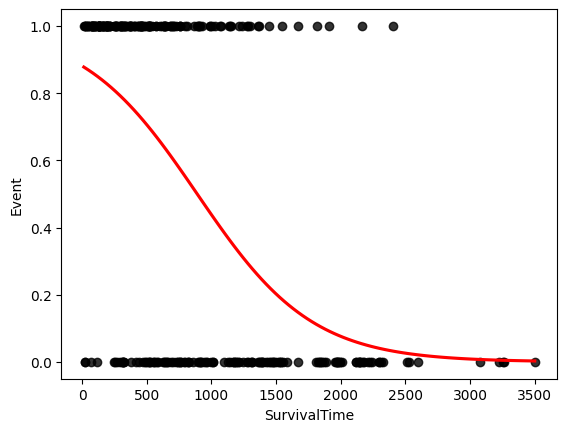

In [89]:
sns.regplot(x=X_train, y=y_train, data=df_out, logistic=True, ci=None, scatter_kws={'color': 'black'}, line_kws={'color': 'red'})

In [56]:
df_rd = pd.read_csv('random_submission_0vhlEZN.csv')
mb, nb =df_rd.shape
print('Shape of random :')
print('Number of features :', nb)
print('Number of rows :', mb)
df_rd.head()

Shape of random :
Number of features : 3
Number of rows : 125


,PatientID,SurvivalTime,Event
0,13,788.417673,NaN
1,155,427.650092,NaN
2,404,173.587222,NaN
3,407,389.877973,NaN
4,9,1580.767244,NaN


In [93]:
archive = np.load('data_9Cbe5hx/images/patient_234.npz')
scan = archive['scan']
mask = archive['mask']
m, n, o = mask.shape
p, q, r = scan.shape
print('shape of mask :', m, n, o)
print('shape of scan :', p, q, r)


shape of mask : 92 92 92
shape of scan : 92 92 92


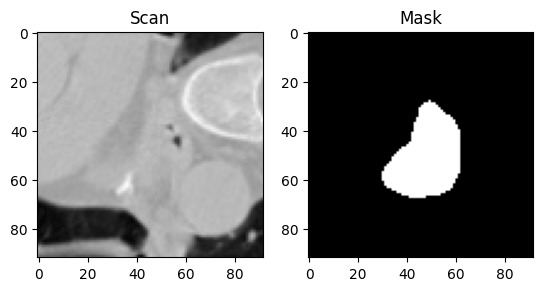

In [115]:
# Load the scan and mask arrays
archive = np.load('data_9Cbe5hx/images/patient_407.npz')
scan = archive['scan']
mask = archive['mask']

# Choose a slice index to display
slice_index = 47  # Adjust this according to the desired slice

# Display the scan slice
plt.subplot(1, 2, 1)
plt.imshow(scan[:, :, slice_index], cmap='gray')
plt.title('Scan')

# Display the mask slice
plt.subplot(1, 2, 2)
plt.imshow(mask[:, :, slice_index], cmap='gray')
plt.title('Mask')

plt.show()